# Imports and Device

In [1]:
import torch
import random
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch.nn as nn
import torch.nn.functional as F

import math
import time

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Data Loading

## First check the shapes and stuff

In [3]:
root_path = "/scratch/04703/sravula/UTAFSDataNew/new_data"
chip_num = 3

In [4]:
import utils

data_dict = utils.grab_chip_data(root_path, chip_num, resample=True)

In [5]:
data_dict.keys()

dict_keys(['gt_matrix', 'gt_freqs', 'vf_matrix', 'y_matrix', 'y_freqs', 'og_matrix', 'og_freqs'])

In [6]:
print(data_dict['gt_matrix'].shape)
print(data_dict['vf_matrix'].shape)
print(data_dict['y_matrix'].shape)
print(data_dict['og_matrix'].shape)

print(data_dict['gt_freqs'].shape)
print(data_dict['y_freqs'].shape)
print(data_dict['og_freqs'].shape)

(128, 4, 4, 2)
(101, 4, 4, 2)
(13, 4, 4, 2)
(101, 4, 4, 2)
(128,)
(13,)
(101,)


## Look at the frequencies to see if there's equal-ish spacing

NUM UNIQUE SPACINGS:  9
[1.00000000e+04 7.18188823e+04 5.87614068e+05 4.80779263e+06
 3.93368219e+07 3.21849480e+08 2.63333647e+09 3.37500000e+09
 6.75000000e+09]


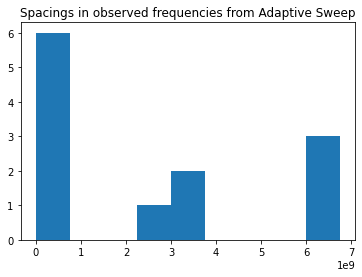

In [7]:
diff_vals = []

for i in range(len(data_dict['y_freqs'])):
    if i == len(data_dict['y_freqs'])-1:
        break
    diff_vals.append(data_dict['y_freqs'][i+1]-data_dict['y_freqs'][i])

unique_vals = np.unique(diff_vals)
print("NUM UNIQUE SPACINGS: ", str(len(unique_vals)))
print(unique_vals)
    
plt.plot()
plt.hist(diff_vals, bins = len(unique_vals))
plt.title("Spacings in observed frequencies from Adaptive Sweep")
plt.show()

NUM UNIQUE SPACINGS:  7
[1.00000000e+04 3.03030200e+08 3.03030202e+08 3.03030204e+08
 3.03030210e+08 3.03030240e+08 3.03030300e+08]


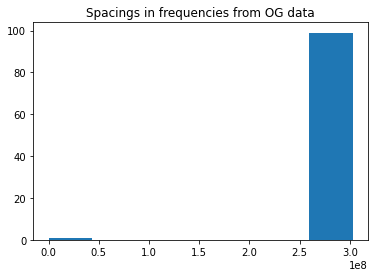

In [8]:
diff_vals = []

for i in range(len(data_dict['og_freqs'])):
    if i == len(data_dict['og_freqs'])-1:
        break
    diff_vals.append(data_dict['og_freqs'][i+1]-data_dict['og_freqs'][i])

    
unique_vals = np.unique(diff_vals)
print("NUM UNIQUE SPACINGS: ", str(len(unique_vals)))
print(unique_vals)

plt.plot()
plt.hist(diff_vals, bins = len(unique_vals))
plt.title("Spacings in frequencies from OG data")
plt.show()

NUM UNIQUE SPACINGS:  9
[2.36220472e+08 2.36220472e+08 2.36220472e+08 2.36220472e+08
 2.36220472e+08 2.36220472e+08 2.36220472e+08 2.36220472e+08
 2.36220472e+08]


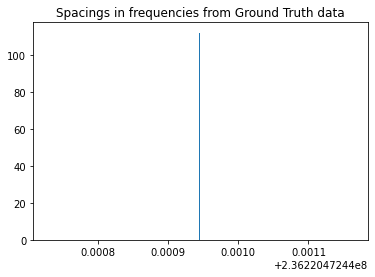

In [9]:
diff_vals = []

for i in range(len(data_dict['gt_freqs'])):
    if i == len(data_dict['gt_freqs'])-1:
        break
    diff_vals.append(data_dict['gt_freqs'][i+1]-data_dict['gt_freqs'][i])

    
unique_vals = np.unique(diff_vals)
print("NUM UNIQUE SPACINGS: ", str(len(unique_vals)))
print(unique_vals)

plt.plot()
plt.hist(diff_vals, bins = len(unique_vals))
plt.title("Spacings in frequencies from Ground Truth data")
plt.show()

## Convert the three datas into more usable forms and see what's up

In [10]:
vf_data = utils.matrix_to_sparams(data_dict['vf_matrix'])
gt_data = utils.matrix_to_sparams(data_dict['gt_matrix'])
y_data = utils.matrix_to_sparams(data_dict['y_matrix'])
og_data = utils.matrix_to_sparams(data_dict['og_matrix'])

In [11]:
print(vf_data.shape)
print(gt_data.shape)
print(y_data.shape)
print(og_data.shape)

(10, 2, 101)
(10, 2, 128)
(10, 2, 13)
(10, 2, 101)


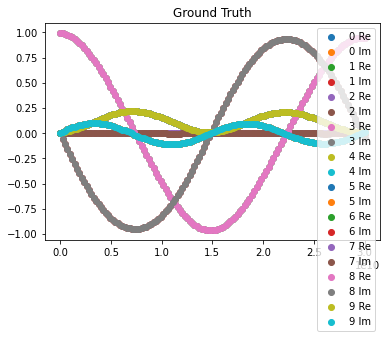

In [12]:
n_sparams = gt_data.shape[0]

plt.figure()
for i in range(n_sparams):
    plt.scatter(data_dict['gt_freqs'], gt_data[i,0,:].squeeze(), label=str(i)+" Re")
    plt.scatter(data_dict['gt_freqs'], gt_data[i,1,:].squeeze(), label=str(i)+" Im")
plt.legend()
plt.title("Ground Truth")
plt.show()

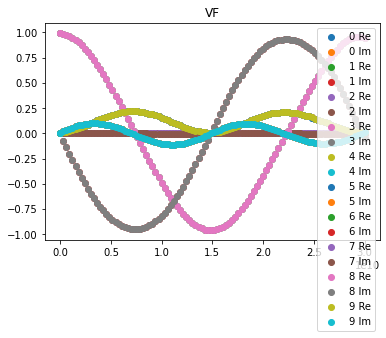

In [13]:
plt.figure()
for i in range(n_sparams):
    plt.scatter(data_dict['og_freqs'], vf_data[i,0,:].squeeze(), label=str(i)+" Re")
    plt.scatter(data_dict['og_freqs'], vf_data[i,1,:].squeeze(), label=str(i)+" Im")
plt.legend()
plt.title("VF")
plt.show()

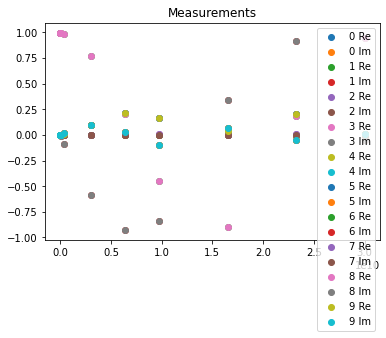

In [14]:
plt.figure()
for i in range(n_sparams):
    plt.scatter(data_dict['y_freqs'], y_data[i,0,:].squeeze(), label=str(i)+" Re")
    plt.scatter(data_dict['y_freqs'], y_data[i,1,:].squeeze(), label=str(i)+" Im")
plt.legend()
plt.title("Measurements")
plt.show()

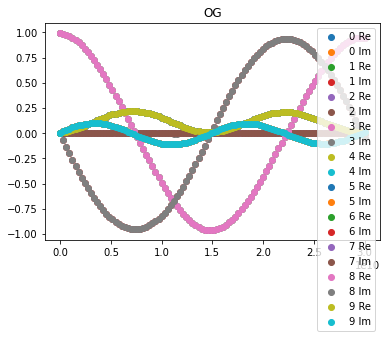

In [15]:
plt.figure()
for i in range(n_sparams):
    plt.scatter(data_dict['og_freqs'], og_data[i,0,:].squeeze(), label=str(i)+" Re")
    plt.scatter(data_dict['og_freqs'], og_data[i,1,:].squeeze(), label=str(i)+" Im")
plt.legend()
plt.title("OG")
plt.show()

## Check the frequencies to see what's up

In [16]:
print(data_dict['og_freqs'])

[0.00000000e+00 1.00000000e+04 3.03040202e+08 6.06070404e+08
 9.09100606e+08 1.21213081e+09 1.51516101e+09 1.81819121e+09
 2.12122141e+09 2.42425162e+09 2.72728182e+09 3.03031202e+09
 3.33334222e+09 3.63637242e+09 3.93940263e+09 4.24243283e+09
 4.54546303e+09 4.84849323e+09 5.15152343e+09 5.45455364e+09
 5.75758384e+09 6.06061404e+09 6.36364424e+09 6.66667444e+09
 6.96970465e+09 7.27273485e+09 7.57576505e+09 7.87879525e+09
 8.18182545e+09 8.48485566e+09 8.78788586e+09 9.09091606e+09
 9.39394626e+09 9.69697646e+09 1.00000067e+10 1.03030369e+10
 1.06060671e+10 1.09090973e+10 1.12121275e+10 1.15151577e+10
 1.18181879e+10 1.21212181e+10 1.24242483e+10 1.27272785e+10
 1.30303087e+10 1.33333389e+10 1.36363691e+10 1.39393993e+10
 1.42424295e+10 1.45454597e+10 1.48484899e+10 1.51515201e+10
 1.54545503e+10 1.57575805e+10 1.60606107e+10 1.63636409e+10
 1.66666711e+10 1.69697013e+10 1.72727315e+10 1.75757617e+10
 1.78787919e+10 1.81818221e+10 1.84848523e+10 1.87878825e+10
 1.90909127e+10 1.939394

In [18]:
print(data_dict['gt_freqs'])

[0.00000000e+00 2.36220472e+08 4.72440945e+08 7.08661417e+08
 9.44881890e+08 1.18110236e+09 1.41732283e+09 1.65354331e+09
 1.88976378e+09 2.12598425e+09 2.36220472e+09 2.59842520e+09
 2.83464567e+09 3.07086614e+09 3.30708661e+09 3.54330709e+09
 3.77952756e+09 4.01574803e+09 4.25196850e+09 4.48818898e+09
 4.72440945e+09 4.96062992e+09 5.19685039e+09 5.43307087e+09
 5.66929134e+09 5.90551181e+09 6.14173228e+09 6.37795276e+09
 6.61417323e+09 6.85039370e+09 7.08661417e+09 7.32283465e+09
 7.55905512e+09 7.79527559e+09 8.03149606e+09 8.26771654e+09
 8.50393701e+09 8.74015748e+09 8.97637795e+09 9.21259843e+09
 9.44881890e+09 9.68503937e+09 9.92125984e+09 1.01574803e+10
 1.03937008e+10 1.06299213e+10 1.08661417e+10 1.11023622e+10
 1.13385827e+10 1.15748031e+10 1.18110236e+10 1.20472441e+10
 1.22834646e+10 1.25196850e+10 1.27559055e+10 1.29921260e+10
 1.32283465e+10 1.34645669e+10 1.37007874e+10 1.39370079e+10
 1.41732283e+10 1.44094488e+10 1.46456693e+10 1.48818898e+10
 1.51181102e+10 1.535433